In [1]:
import sys, pathlib
ROOT = pathlib.Path.cwd().resolve()
while ROOT.name != "Implementation_human_mouse" and ROOT != ROOT.parent:
    ROOT = ROOT.parent
if ROOT.name != "Implementation_human_mouse":
    raise RuntimeError("Could not find repo root 'Implementation_human_mouse'")

sys.path.insert(0, str(ROOT))  

import os, pickle, random
import numpy as np
import torch
from torch.utils.data import DataLoader
from copy import deepcopy

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from src.pytorch_models import LightningRNNModule
from src.dataset        import RuleBasedTasks, collate_fn


In [2]:
run_folder = "floral-yogurt-181_fdgo_s1_fdgo_v1_reactgo_s1_reactgo_v1_delaygo_s1_delaygo_v1_fdanti_s1_fdanti_v1_reactanti_s1_reactanti_v1_delayanti_s1_delayanti_v1_dmsgo_dmsnogo_dmcgo_dmcnogo_Sp_4_p-bfd_4_p_4"        
  
checkpoint_dir = ROOT / "saved_models" / "cernn" / run_folder
print("Checkpoint dir →", checkpoint_dir)
if not checkpoint_dir.exists():
    raise FileNotFoundError(checkpoint_dir)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

ckpt_files = sorted(f for f in os.listdir(checkpoint_dir) if f.endswith(".ckpt"))
if not ckpt_files:
    raise FileNotFoundError("No .ckpt files in " + str(checkpoint_dir))
ckpt_path = os.path.join(checkpoint_dir, ckpt_files[0])
print("▶ Loading checkpoint:", ckpt_path)

with open(os.path.join(checkpoint_dir, "hp_pl_module.pkl"), "rb") as f:
    hp_pl_module = pickle.load(f)
with open(os.path.join(checkpoint_dir, "task_hp.pkl"), "rb") as f:
    task_hp = pickle.load(f)

model = LightningRNNModule.load_from_checkpoint(ckpt_path, strict=False).to(device)  # strict=False is safer across versions
model.eval().freeze()


def _get_hparam(*keys, default=None):
    cur = hp_pl_module
    for k in keys:
        if not hasattr(cur, k):
            cur = None; break
        cur = getattr(cur, k)
    if cur is not None: return cur
    if hasattr(model, "hparams"):
        h = dict(model.hparams)
        dotted = ".".join(keys)
        if dotted in h:   return h[dotted]
        if keys[-1] in h: return h[keys[-1]]
    return default

UNITS          = int(_get_hparam("embedding", "n_units", default=43))
SEED_EMBEDDING = int(_get_hparam("embedding", "seed",    default=0))
SPECIES        =      _get_hparam("species", default=getattr(hp_pl_module, "species", "mouse")) 
GLOBAL_SEED    =      _get_hparam("seed", default=42)
SEED = SEED_EMBEDDING if GLOBAL_SEED is None else int(GLOBAL_SEED)
print(f"global SEED: {GLOBAL_SEED}")
print(f"Embedding seed: {SEED_EMBEDDING}")

np.random.seed(SEED); torch.manual_seed(SEED); random.seed(SEED)
torch_gen = torch.Generator().manual_seed(SEED)

from src import task as _task_mod 
ckpt_rules = list(task_hp["rule_trains"])   
print("\n[INFO] Rules from checkpoint:", ckpt_rules) 
# Override the global table used by get_rule_index():
_task_mod.rules_dict["all"] = ckpt_rules      
# Recompute rule-dependent hp to be safe


# § --- make get_rule_index checkpoint-aware (prevents index > n_input-1) ---
try:
    _orig_get_rule_index = _task_mod.get_rule_index                             
except AttributeError:
    _orig_get_rule_index = None                                                 

def _get_rule_index_ckpt(rule, config=None):                                    
    base = int(task_hp_det.get("rule_start", 1 + num_ring * n_eachring))        
    # Prefer the checkpoint’s rules (what the model was trained with)
    if rule in ckpt_rules:                                                      
        return base + ckpt_rules.index(rule)                                    
    # Fallback to original behavior if needed (other scripts might call this)
    if _orig_get_rule_index is not None:                                        
        return _orig_get_rule_index(rule, config)                               
    raise KeyError(f"Unknown rule: {rule}")                                     

_task_mod.get_rule_index = _get_rule_index_ckpt                                 

num_ring       = task_hp.get("num_ring", task_hp.get("num_ring", 1))
n_eachring     = task_hp.get("n_eachring", task_hp.get("n_eachring", 2))
task_hp["n_rule"]     = len(ckpt_rules)       
task_hp["rule_trains"] = ckpt_rules           
task_hp["rules"]       = ckpt_rules         
task_hp["rule_start"]  = 1 + num_ring * n_eachring 
task_hp["n_input"]     = 1 + num_ring * n_eachring + task_hp["n_rule"] 

# Make a deterministic copy of hp
from copy import deepcopy
task_hp_det        = deepcopy(task_hp)
import numpy as np
task_hp_det["rng"] = np.random.RandomState(SEED)  

Checkpoint dir → /Users/hsuyatikhin/Downloads/UoB/UoB Data Science (MSc)/8. Data Science Project 2024/###Final Dissertation/Implementation_human_mouse/saved_models/cernn/floral-yogurt-181_fdgo_s1_fdgo_v1_reactgo_s1_reactgo_v1_delaygo_s1_delaygo_v1_fdanti_s1_fdanti_v1_reactanti_s1_reactanti_v1_delayanti_s1_delayanti_v1_dmsgo_dmsnogo_dmcgo_dmcnogo_Sp_4_p-bfd_4_p_4
Using device: cpu
▶ Loading checkpoint: /Users/hsuyatikhin/Downloads/UoB/UoB Data Science (MSc)/8. Data Science Project 2024/###Final Dissertation/Implementation_human_mouse/saved_models/cernn/floral-yogurt-181_fdgo_s1_fdgo_v1_reactgo_s1_reactgo_v1_delaygo_s1_delaygo_v1_fdanti_s1_fdanti_v1_reactanti_s1_reactanti_v1_delayanti_s1_delayanti_v1_dmsgo_dmsnogo_dmcgo_dmcnogo_Sp_4_p-bfd_4_p_4/epoch=186-val_perf=0.93.ckpt
{2: 4, 20: 4, 30: 4}
visual start 2 visual end 6
somatosensory start 23 somatosensory end 27
{2: 4, 20: 4, 30: 4}
{2: 4, 20: 4, 30: 4}
global SEED: 42
Embedding seed: 0

[INFO] Rules from checkpoint: ['fdgo_s1', 'fdgo_

In [3]:

RULE_FOR_PCA = "fdgo_s1" #r first choice
print(f"[INFO] Using rule for PCA: {RULE_FOR_PCA}") 

# Use mode="test" to iterate rules deterministically, one batch per rule
dl = DataLoader(
    RuleBasedTasks(task_hp_det, mode="test"), batch_size=1,
    collate_fn=collate_fn, shuffle=False, generator=torch_gen
)

# Scan for the requested rule
batch = None
for b in dl:
    if getattr(b, "rule", None) == RULE_FOR_PCA:
        batch = b
        break
if batch is None:
    print("[WARN] Rule not found in test iterator; falling back to train iterator")
    dl_train = DataLoader(
        RuleBasedTasks(task_hp_det, mode="train"), batch_size=1,
        collate_fn=collate_fn, shuffle=True, generator=torch_gen
    )
    for b in dl_train:
        if getattr(b, "rule", None) == RULE_FOR_PCA:
            batch = b
            break
if batch is None:
    raise RuntimeError(f"Could not find/generate a batch for rule {RULE_FOR_PCA}")

batch.x, batch.c_mask = batch.x.to(device), batch.c_mask.to(device)
with torch.no_grad():
    _, h = model.eval_step(batch)

H = h[:, 0, :].cpu().numpy()          # (T, UNITS)
T = H.shape[0]
print(f"Timesteps (T): {T}, UNITS: {UNITS}")

# Fixation window
s_fix_raw, e_fix_raw = batch.epochs.get("fix1", (None, None))
s_fix = 0 if s_fix_raw is None else int(s_fix_raw)
e_fix = T if e_fix_raw is None else int(e_fix_raw)
s_fix = max(0, min(s_fix, T)); e_fix = max(0, min(e_fix, T))

# Baseline = mean over fixation, per unit
baseline = H[s_fix:e_fix].mean(axis=0)            # (UNITS,)
H_bs = H - baseline                               # (T, UNITS)  keep fixation included

# Build epoch segments on full timebase
SEGMENTS_FULL = []
for name, (s, e) in batch.epochs.items():
    s0 = 0 if s is None else int(s)
    e0 = T if e is None else int(e)
    # s0 = max(0, min(s0, T)); e0 = max(0, min(e0, T))
    if e0 > s0:
        SEGMENTS_FULL.append((name, s0, e0))
SEGMENTS_FULL.sort(key=lambda x: x[1])

print("\n=== DEBUG: epochs (start, end, length) ===")
for name, s0, e0 in SEGMENTS_FULL:
    print(f"{name:>8s}: ({s0:3d}, {e0:3d})  len={e0-s0}")

# § Onset indices for vertical lines
ONSETS = [(name, s0) for name, s0, e0 in SEGMENTS_FULL] 
print("Onsets:", ONSETS) 

# Diagnostics: how well did fixation-mean subtraction zero the fixation mean?
fix_mean_after = H_bs[s_fix:e_fix].mean(axis=0)          # (UNITS,)
fix_mean_L2    = float(np.linalg.norm(fix_mean_after))
fix_mean_max   = float(np.max(np.abs(fix_mean_after)))

# Timewise norms during fixation (after subtraction)
fix_L2_time = np.linalg.norm(H_bs[s_fix:e_fix], axis=1)  # (e_fix - s_fix,)

print("\n=== DEBUG: baseline subtraction check (fixation) ===")
print(f"Fix window: [{s_fix}, {e_fix})  n={e_fix-s_fix}")
print(f"||mean(fix, after)||_2 = {fix_mean_L2:.6g}   max|mean_i| = {fix_mean_max:.6g}")
print(f"First 5 timepoint norms in fixation (after): {fix_L2_time[:5]}")
print(f"Min/Median/Max fixation timepoint norms: {np.min(fix_L2_time):.4g} / {np.median(fix_L2_time):.4g} / {np.max(fix_L2_time):.4g}")

[INFO] Using rule for PCA: fdgo_s1
Timesteps (T): 100, UNITS: 43

=== DEBUG: epochs (start, end, length) ===
    fix1: (  0,  25)  len=25
   stim1: ( 25,  75)  len=50
     go1: ( 75, 100)  len=25
Onsets: [('fix1', 0), ('stim1', 25), ('go1', 75)]

=== DEBUG: baseline subtraction check (fixation) ===
Fix window: [0, 25)  n=25
||mean(fix, after)||_2 = 2.85497e-07   max|mean_i| = 1.16825e-07
First 5 timepoint norms in fixation (after): [0.6241549  0.5388209  0.46431533 0.39864215 0.31633833]
Min/Median/Max fixation timepoint norms: 0.08184 / 0.2514 / 0.6242


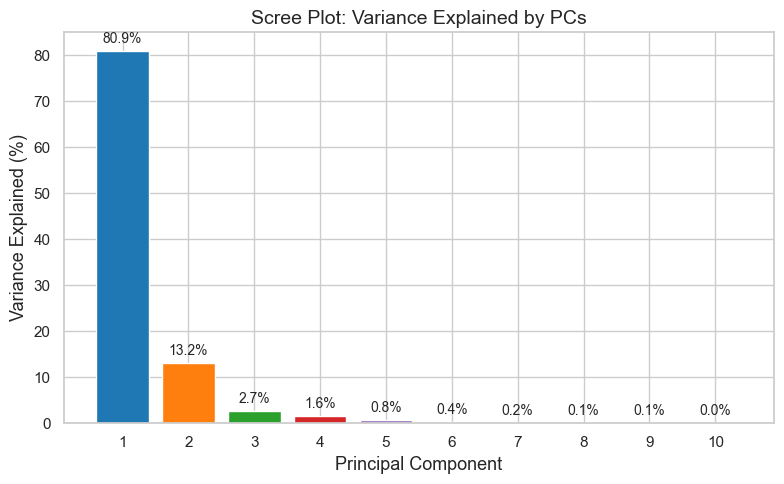

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA

sns.set(style="whitegrid")
color_palette = sns.color_palette("tab10")

# --- PCA on baseline-subtracted activity ---
n_pcs_to_keep = min(UNITS, 10)
pca = PCA(n_components=n_pcs_to_keep)
Z = pca.fit_transform(H_bs)         # (T, n_pcs_to_keep)
explained_var = pca.explained_variance_ratio_

# --- Variance explained (scree plot) ---
plt.figure(figsize=(8,5))
bars = plt.bar(
    range(1, n_pcs_to_keep+1),
    explained_var*100,
    color=color_palette[:n_pcs_to_keep]
)

# Add text labels
for i, v in enumerate(explained_var*100):
    plt.text(i+1, v+1, f"{v:.1f}%", ha='center', va='bottom', fontsize=10)

plt.xlabel("Principal Component", fontsize=13)
plt.ylabel("Variance Explained (%)", fontsize=13)
plt.title("Scree Plot: Variance Explained by PCs", fontsize=14)
plt.xticks(range(1, n_pcs_to_keep+1))
plt.tight_layout()
plt.show()


In [6]:
from pathlib import Path
import itertools

unit_labels = None
# Prefer labels from the model (works for both human & mouse)
if hasattr(model, "ce") and hasattr(model.ce, "area_labels"):
    unit_labels = list(model.ce.area_labels)

# Fallback: species-aware disk path
if unit_labels is None or len(unit_labels) != UNITS:
    lbl_path = (ROOT / "src" / "data" / "mouse_area_names.txt")
    if not lbl_path.exists():
        raise FileNotFoundError(f"Could not find label_names.txt at {lbl_path}")
    with open(lbl_path, "r") as f:
        unit_labels = [ln.strip() for ln in f.readlines()]

    # 🔧 Expand labels if fewer than UNITS
    if len(unit_labels) < UNITS:
        unit_labels = list(itertools.islice(itertools.cycle(unit_labels), UNITS))

assert len(unit_labels) == UNITS, (len(unit_labels), UNITS)
print(f"[labels] species={SPECIES}  units={UNITS}  (first 10):", unit_labels[:10])


[labels] species=mouse  units=43  (first 10): ['VISpl', 'VISpor', 'VISp', 'RSPagl', 'RSPd', 'VISl', 'PERI', 'VISli', 'ECT', 'TEa']


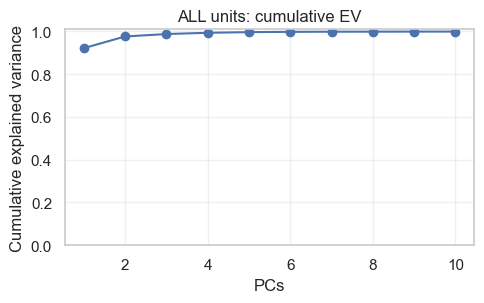

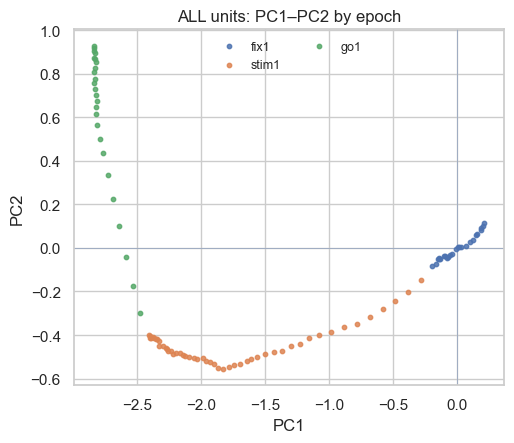

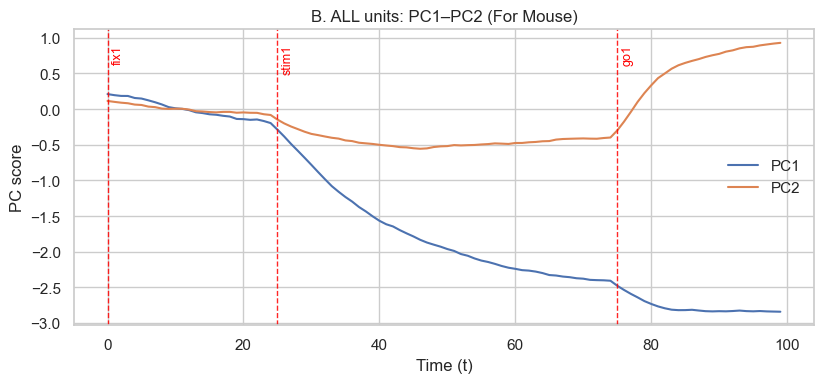

In [7]:
# Baseline subtraction only --> PCA on H_bs (no normalization) 

import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple, Any

def _segments_to_items(segments: Any) -> List[Tuple[str, Tuple[int,int]]]:       
    if isinstance(segments, dict):
        items = [(k, tuple(v)) for k, v in segments.items()]
    else:
        items = []
        for i, el in enumerate(segments):
            if isinstance(el, (list, tuple)):
                if len(el) == 2 and isinstance(el[0], str):
                    name, (st, en) = el[0], el[1]; items.append((name, (int(st), int(en))))
                elif len(el) == 3 and isinstance(el[0], str):
                    name, st, en = el; items.append((name, (int(st), int(en))))
                elif len(el) == 2 and all(isinstance(x, (int, np.integer)) for x in el):
                    items.append((f"epoch_{i+1}", (int(el[0]), int(el[1]))))
                else:
                    raise ValueError(f"Bad epoch spec at {i}: {el}")
            else:
                raise ValueError(f"Epoch entry {i} must be tuple/list.")
    return sorted(items, key=lambda kv: kv[1][0])

SEG_ITEMS = _segments_to_items(SEGMENTS_FULL)                                     

# 1) Baseline subtraction
mu_fix = H[s_fix:e_fix, :].mean(axis=0, keepdims=True)                            
X_full = H - mu_fix                                                                # no further scaling

# 2) PCA via SVD on baseline-subtracted data (all timepoints)
U, S, Vt   = np.linalg.svd(X_full, full_matrices=False)                            
k          = min(10, Vt.shape[0])                                                  
components = Vt[:k, :]                                                             
Z_all      = X_full @ components.T                                                 
expl_var   = (S[:k]**2) / np.sum(S**2)                                             
cum_expl   = np.cumsum(expl_var)                                                   

# 3) Plots
def _epoch_boundaries_and_labels(items): onsets=[st for _,(st,_) in items]; names=[nm for nm,_ in items]; return onsets, names 
def _plot_explained_variance_cumulative(cum, title):
    plt.figure(figsize=(5,3.2)); plt.plot(np.arange(1,len(cum)+1), cum, marker='o')
    plt.xlabel("PCs"); plt.ylabel("Cumulative explained variance"); plt.ylim(0,1.01)
    plt.title(title); plt.grid(True,alpha=0.3); plt.tight_layout(); plt.show()
def _scatter_pc12_by_epoch(Z, items, title):
    plt.figure(figsize=(5.3,4.6))
    for i,(nm,(st,en)) in enumerate(items): plt.scatter(Z[st:en,0], Z[st:en,1], s=10, alpha=0.85, label=nm)
    plt.axhline(0,lw=0.6,alpha=0.4); plt.axvline(0,lw=0.6,alpha=0.4)
    plt.xlabel("PC1"); plt.ylabel("PC2"); plt.title(title); plt.legend(frameon=False,fontsize=9,ncol=2)
    plt.tight_layout(); plt.show()
def _plot_pc_timecourses(Z, items, title, pcs=(0,1,2)):
    plt.figure(figsize=(8.4,4.0))
    for p in pcs:
        if p < Z.shape[1]: plt.plot(Z[:,p], label=f"PC{p+1}")
    onsets, names = _epoch_boundaries_and_labels(SEG_ITEMS); ax=plt.gca()
    for x, nm in zip(onsets, names):
        ax.axvline(x, color="red", linestyle="--", linewidth=1.0, alpha=0.85)
        y0,y1=ax.get_ylim(); plt.text(x+0.6, y0+0.95*(y1-y0), nm, color="red", fontsize=9, rotation=90, va="top")
    plt.xlabel("Time (t)"); plt.ylabel("PC score"); plt.title(title); plt.legend(frameon=False)
    plt.tight_layout(); plt.show()

_plot_explained_variance_cumulative(cum_expl, "ALL units: cumulative EV")       
_scatter_pc12_by_epoch(Z_all, SEG_ITEMS, "ALL units: PC1–PC2 by epoch")         
_plot_pc_timecourses(Z_all, SEG_ITEMS, "B. ALL units: PC1–PC2 (For Mouse)", pcs=(0,1))   

# # 4) Networks in same PC space
# def project_network_in_all_pc_space(mask_bool: np.ndarray) -> np.ndarray:         
#     Xm = X_full.copy(); Xm[:, ~mask_bool] = 0.0                                    
#     return Xm @ components.T                                                       

# for net_name, mask in net_masks.items():                                          
#     if mask.sum() < 2: print(f"[skip] {net_name}: not enough units ({mask.sum()})"); continue
#     Z_net = project_network_in_all_pc_space(mask)
#     _scatter_pc12_by_epoch(Z_net, SEG_ITEMS, f"{net_name}: PC1–PC2")           
#     _plot_pc_timecourses(Z_net, SEG_ITEMS, f"{net_name}: PC1–PC2–PC3", pcs=(0,1,2)) 
